In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
import matplotlib.patches as mpatches
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,r2_score
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop

import os

In [2]:
plt.style.use('fivethirtyeight')

In [3]:
df1=pd.read_excel(r'C:\Users\ASUS-PC\Desktop\CIL\Quote-Equity-COALINDIA-EQ-01-01-2019-to-31-12-2020.xlsx')
df2=pd.read_excel(r'C:\Users\ASUS-PC\Desktop\CIL\Quote-Equity-COALINDIA-EQ-01-01-2021-to-24-06-2022.xlsx')

In [4]:
data=pd.concat([df1,df2],axis=0)

In [5]:
data.tail(5)

,Date,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
362,2022-06-20,EQ,181.90,181.90,174.75,182.65,178.00,176.85,177.90,209.0,132.75,23276003,4.140882e+09,79840
363,2022-06-21,EQ,178.00,185.65,178.00,176.85,185.15,184.80,182.38,209.0,132.75,7564329,1.379595e+09,47069
364,2022-06-22,EQ,184.75,184.75,179.00,184.80,179.50,179.35,181.51,209.0,132.75,6560404,1.190789e+09,66391
365,2022-06-23,EQ,180.30,182.00,174.85,179.35,177.35,177.15,177.86,209.0,132.75,9304799,1.654945e+09,76522
366,2022-06-24,EQ,178.65,180.40,174.80,177.15,176.75,176.55,177.11,209.0,132.75,8171322,1.447182e+09,60334


In [6]:
data.shape

(864, 14)

In [7]:
data.Date=pd.to_datetime(data['Date '])

<ipython-input-7-bd14e7737f87>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  data.Date=pd.to_datetime(data['Date '])


In [8]:
data.set_index('Date ',inplace=True)

In [9]:
data.tail(10)

,series,OPEN,HIGH,LOW,PREV. CLOSE,ltp,close,vwap,52W H,52W L,VOLUME,VALUE,No of trades
Date,,,,,,,,,,,,,
2022-06-13,EQ,196.65,197.40,189.55,198.50,191.55,191.05,192.62,209.0,132.75,8516696,1.640525e+09,72164
2022-06-14,EQ,189.10,194.50,189.10,191.05,192.20,192.20,192.08,209.0,132.75,6727598,1.292216e+09,66990
2022-06-15,EQ,192.15,193.85,189.15,192.20,190.25,190.05,190.44,209.0,132.75,5805589,1.105615e+09,44970
2022-06-16,EQ,191.55,192.80,179.10,190.05,179.80,179.90,185.31,209.0,132.75,14490962,2.685251e+09,87619
2022-06-17,EQ,180.00,184.85,179.40,179.90,183.95,182.65,182.62,209.0,132.75,15215695,2.778654e+09,83416
2022-06-20,EQ,181.90,181.90,174.75,182.65,178.00,176.85,177.90,209.0,132.75,23276003,4.140882e+09,79840
2022-06-21,EQ,178.00,185.65,178.00,176.85,185.15,184.80,182.38,209.0,132.75,7564329,1.379595e+09,47069
2022-06-22,EQ,184.75,184.75,179.00,184.80,179.50,179.35,181.51,209.0,132.75,6560404,1.190789e+09,66391
2022-06-23,EQ,180.30,182.00,174.85,179.35,177.35,177.15,177.86,209.0,132.75,9304799,1.654945e+09,76522


In [10]:
data.shape

(864, 13)

In [11]:
data=data[['close ']]

In [12]:
data.tail(5)

,close
Date,
2022-06-20,176.85
2022-06-21,184.80
2022-06-22,179.35
2022-06-23,177.15
2022-06-24,176.55


In [13]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 864 number of days in the dataset.


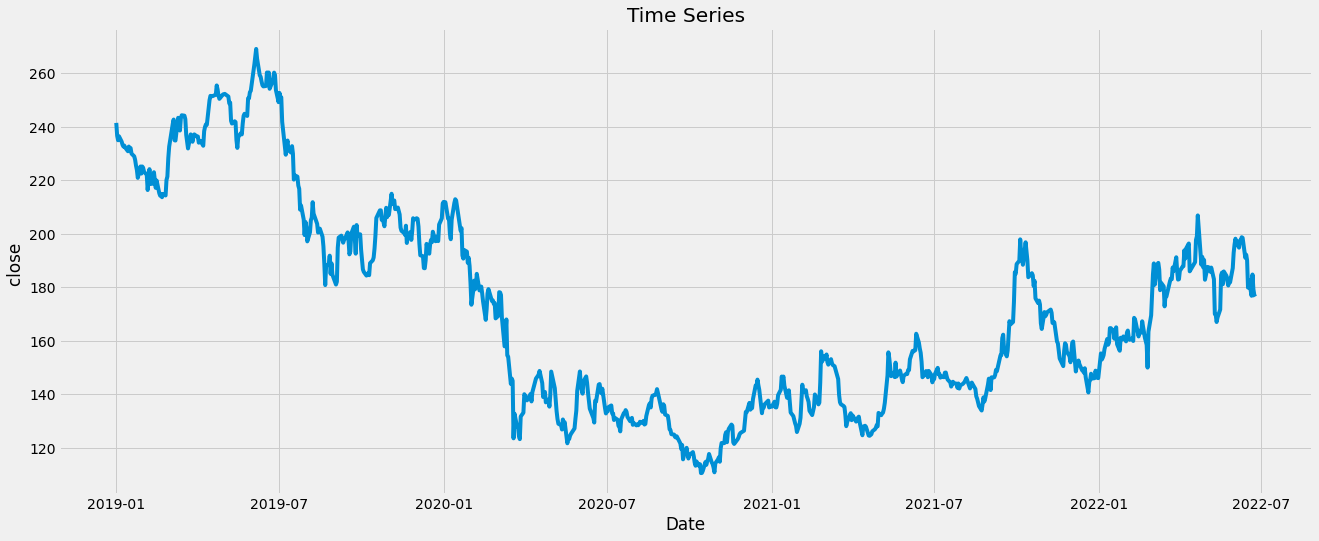

In [14]:
plt.figure(figsize=(20,8))
plt.plot(data)
plt.title('Time Series')
plt.xlabel('Date')
plt.ylabel('close ')
plt.show()

In [15]:
#add technical indicators to get more accurate result.
#create MACD & signal
def get_technical_indicators(dataset):
    dataset['26ema'] = dataset['close '].ewm(span=26).mean()
    dataset['12ema'] = dataset['close '].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']
    dataset['signal'] = dataset['MACD'].ewm(span=9).mean()
    return dataset

In [16]:
df=get_technical_indicators(data)

In [17]:
df.isnull().sum()

close     0
26ema     0
12ema     0
MACD      0
signal    0
dtype: int64

In [18]:
df.head()

,close,26ema,12ema,MACD,signal
Date,,,,,
2019-01-01,241.5,241.500000,241.500000,0.000000,0.000000
2019-01-02,236.7,239.007692,238.900000,-0.107692,-0.059829
2019-01-03,235.0,237.567767,237.377829,-0.189938,-0.113153
2019-01-04,236.5,237.269266,237.100733,-0.168534,-0.131913
2019-01-07,234.5,236.627062,236.394123,-0.232939,-0.161966


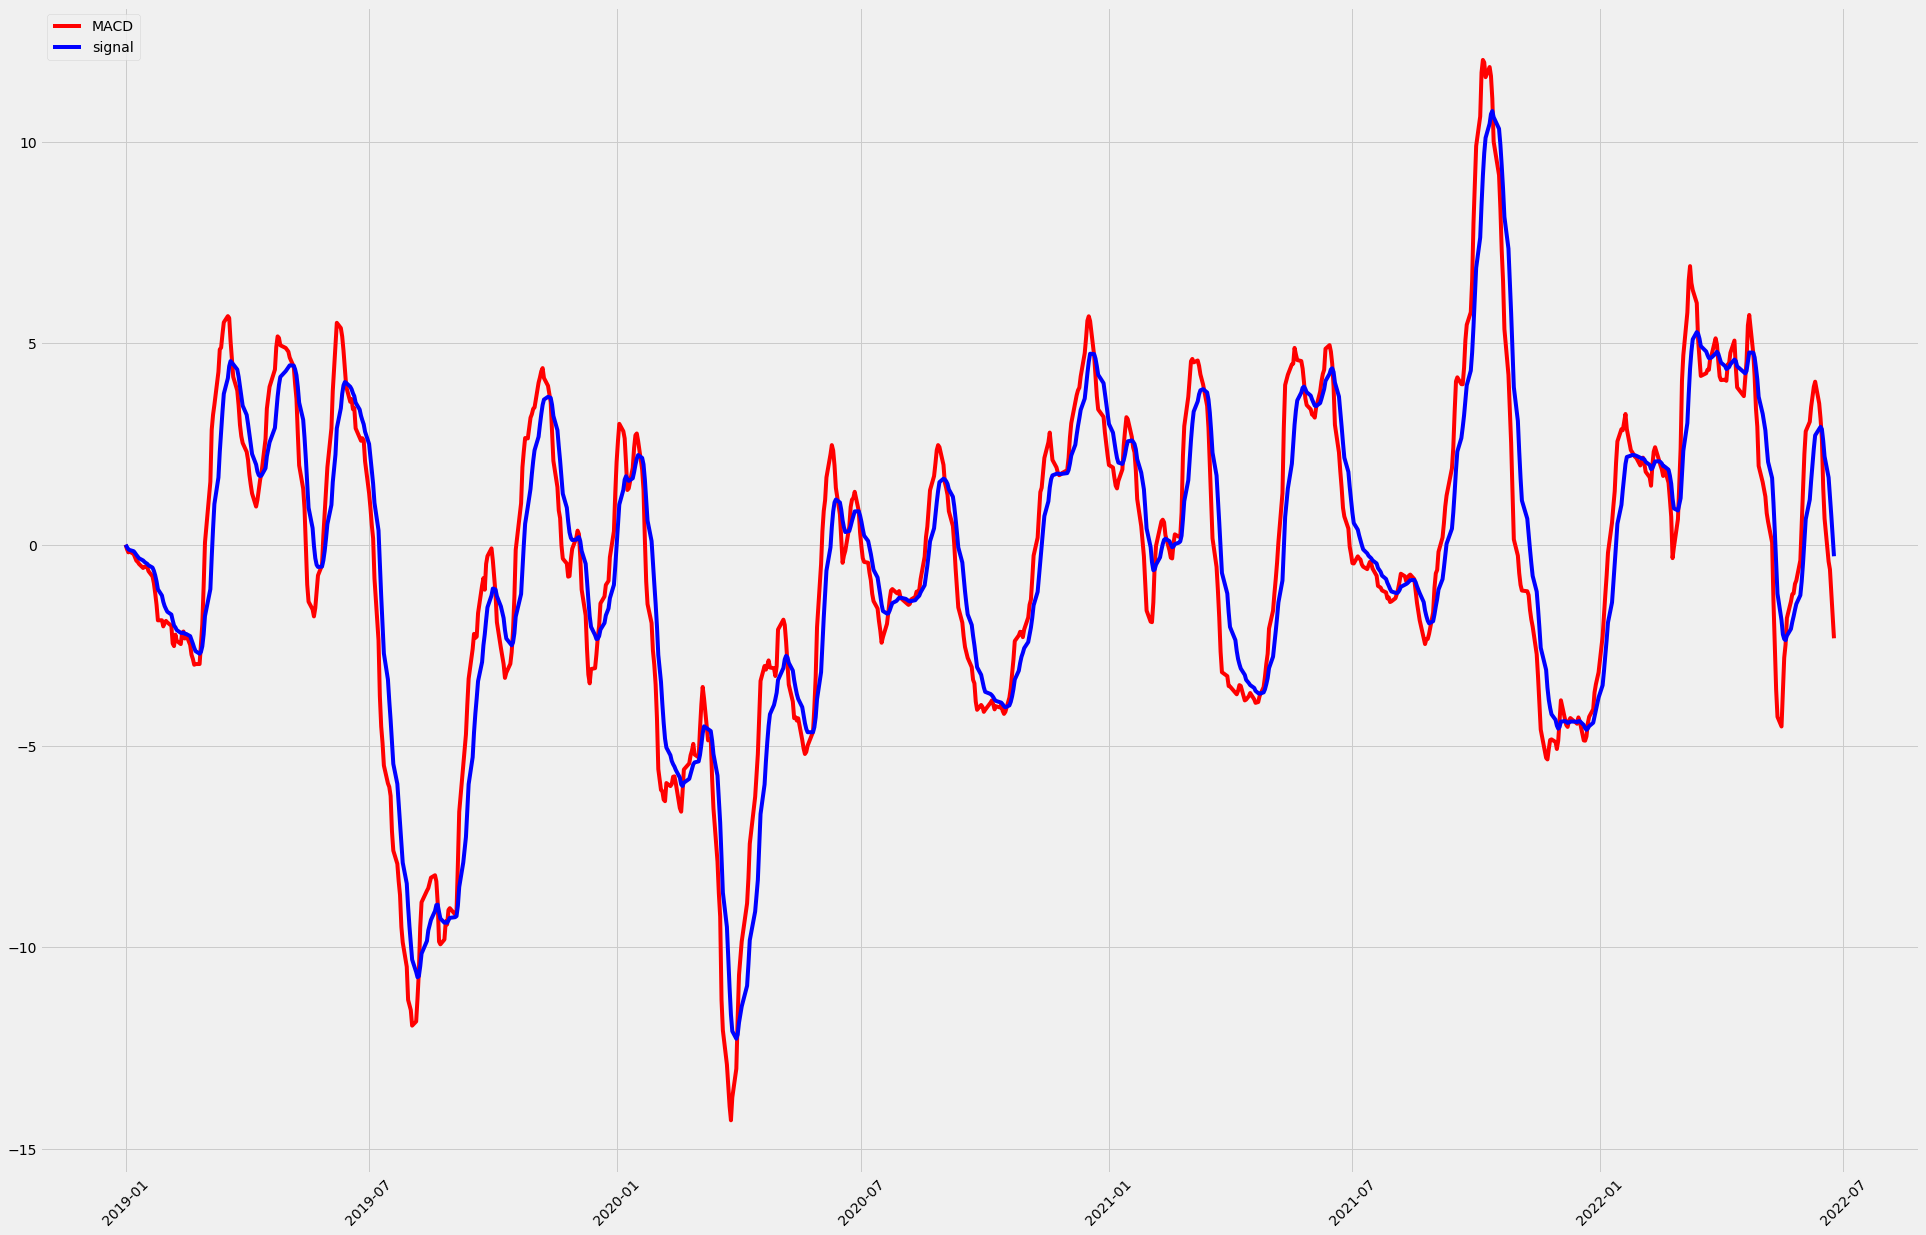

In [19]:
#plot the macd and signal chart
plt.figure(figsize=(30,20))
plt.plot(df.index,df['MACD'],label='MACD',color='red')
plt.plot(df.index,df['signal'],label='signal',color='blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [20]:
x=pd.DataFrame({'Date ':pd.date_range(start="2022-06-27",end="2022-07-02")})

In [21]:
x.tail()

,Date
1,2022-06-28
2,2022-06-29
3,2022-06-30
4,2022-07-01
5,2022-07-02


In [22]:
x.set_index('Date ',inplace=True)

In [23]:
Data=pd.concat([df,x],axis=0)

In [24]:
Data.tail(20)

,close,26ema,12ema,MACD,signal
Date,,,,,
2022-06-07,197.55,187.853469,191.270559,3.417089,1.577431
2022-06-08,197.65,188.579138,192.252011,3.672873,1.996520
2022-06-09,198.75,189.332535,193.251702,3.919166,2.381049
2022-06-10,198.50,190.011607,194.059132,4.047525,2.714344
2022-06-13,191.05,190.088525,193.596189,3.507664,2.873008
2022-06-14,192.20,190.244930,193.381391,3.136460,2.925699
2022-06-15,190.05,190.230491,192.868869,2.638378,2.868234
2022-06-16,179.90,189.465270,190.873658,1.408389,2.576265
2022-06-17,182.65,188.960435,189.608480,0.648045,2.190621


In [25]:
Data.columns

Index(['close ', '26ema', '12ema', 'MACD', 'signal'], dtype='object')

In [26]:
Data['close_lag']=Data['close '].shift(6)
Data['MACD_lag']=Data['MACD'].shift(6)
Data['signal_lag']=Data['signal'].shift(6)

In [27]:
Data.tail()

,close,26ema,12ema,MACD,signal,close_lag,MACD_lag,signal_lag
Date,,,,,,,,
2022-06-28,NaN,NaN,NaN,NaN,NaN,176.85,-0.417728,1.668951
2022-06-29,NaN,NaN,NaN,NaN,NaN,184.80,-0.613788,1.212404
2022-06-30,NaN,NaN,NaN,NaN,NaN,179.35,-1.195159,0.730891
2022-07-01,NaN,NaN,NaN,NaN,NaN,177.15,-1.812528,0.222207
2022-07-02,NaN,NaN,NaN,NaN,NaN,176.55,-2.323429,-0.286920


In [28]:
Data.head(10)

,close,26ema,12ema,MACD,signal,close_lag,MACD_lag,signal_lag
Date,,,,,,,,
2019-01-01,241.50,241.500000,241.500000,0.000000,0.000000,NaN,NaN,NaN
2019-01-02,236.70,239.007692,238.900000,-0.107692,-0.059829,NaN,NaN,NaN
2019-01-03,235.00,237.567767,237.377829,-0.189938,-0.113153,NaN,NaN,NaN
2019-01-04,236.50,237.269266,237.100733,-0.168534,-0.131913,NaN,NaN,NaN
2019-01-07,234.50,236.627062,236.394123,-0.232939,-0.161966,NaN,NaN,NaN
2019-01-08,233.30,235.960678,235.642088,-0.318590,-0.204420,NaN,NaN,NaN
2019-01-09,232.65,235.371891,234.974414,-0.397477,-0.253277,241.5,0.000000,0.000000
2019-01-10,233.00,234.989721,234.562384,-0.427336,-0.295107,236.7,-0.107692,-0.059829
2019-01-11,232.25,234.583634,234.104912,-0.478721,-0.337523,235.0,-0.189938,-0.113153


In [29]:
df_=Data.copy()

In [30]:
df_.tail(15)

,close,26ema,12ema,MACD,signal,close_lag,MACD_lag,signal_lag
Date,,,,,,,,
2022-06-14,192.20,190.244930,193.381391,3.136460,2.925699,194.85,3.051095,1.117517
2022-06-15,190.05,190.230491,192.868869,2.638378,2.868234,197.55,3.417089,1.577431
2022-06-16,179.90,189.465270,190.873658,1.408389,2.576265,197.65,3.672873,1.996520
2022-06-17,182.65,188.960435,189.608480,0.648045,2.190621,198.75,3.919166,2.381049
2022-06-20,176.85,188.063366,187.645637,-0.417728,1.668951,198.50,4.047525,2.714344
2022-06-21,184.80,187.821635,187.207847,-0.613788,1.212404,191.05,3.507664,2.873008
2022-06-22,179.35,187.194106,185.998947,-1.195159,0.730891,192.20,3.136460,2.925699
2022-06-23,177.15,186.450098,184.637571,-1.812528,0.222207,190.05,2.638378,2.868234
2022-06-24,176.55,185.716758,183.393329,-2.323429,-0.286920,179.90,1.408389,2.576265


In [31]:
df_.columns

Index(['close ', '26ema', '12ema', 'MACD', 'signal', 'close_lag', 'MACD_lag',
       'signal_lag'],
      dtype='object')

In [32]:
data_=df_.loc['2019-01-10':,['close_lag','MACD_lag','signal_lag']]
data_.head()

,close_lag,MACD_lag,signal_lag
Date,,,
2019-01-10,236.7,-0.107692,-0.059829
2019-01-11,235.0,-0.189938,-0.113153
2019-01-14,236.5,-0.168534,-0.131913
2019-01-15,234.5,-0.232939,-0.161966
2019-01-16,233.3,-0.318590,-0.204420


In [33]:
data_training=data_[data_.index < '2022-06-27']
data_training.tail(5)

,close_lag,MACD_lag,signal_lag
Date,,,
2022-06-20,198.50,4.047525,2.714344
2022-06-21,191.05,3.507664,2.873008
2022-06-22,192.20,3.136460,2.925699
2022-06-23,190.05,2.638378,2.868234
2022-06-24,179.90,1.408389,2.576265


In [34]:
data_testing=data_[data_.index >= '2022-06-27']
data_testing.tail(10)

,close_lag,MACD_lag,signal_lag
Date,,,
2022-06-27,182.65,0.648045,2.190621
2022-06-28,176.85,-0.417728,1.668951
2022-06-29,184.80,-0.613788,1.212404
2022-06-30,179.35,-1.195159,0.730891
2022-07-01,177.15,-1.812528,0.222207
2022-07-02,176.55,-2.323429,-0.286920


In [35]:
X_train=data_training[['MACD_lag','signal_lag']]
X_test=data_testing[['MACD_lag','signal_lag']]

In [36]:
Y_train=data_training[['close_lag']]
Y_test=data_testing[['close_lag']]

In [37]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(857, 2)
(6, 2)
(857, 1)
(6, 1)


In [38]:
scaler= MinMaxScaler()
Xtrain = scaler.fit_transform(X_train)
Xtest = scaler.fit_transform(X_test)

In [39]:
scaler1= MinMaxScaler()
Ytrain = scaler1.fit_transform(Y_train)
Ytest = scaler1.fit_transform(Y_test)

In [40]:
trainX=np.reshape(Xtrain,(Xtrain.shape[0],1,Xtrain.shape[1]))
testX=np.reshape(Xtest,(Xtest.shape[0],1,Xtest.shape[1]))

In [41]:
print(trainX.shape)
print(testX.shape)

(857, 1, 2)
(6, 1, 2)


In [42]:
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [43]:
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape=(1, 2)))
model.add(Dropout(0.2))
model.add(LSTM(units=80,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=120))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 60)             15120     
                                                                 
 dropout (Dropout)           (None, 1, 60)             0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 80)             45120     
                                                                 
 dropout_1 (Dropout)         (None, 1, 80)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 100)            72400     
                                                                 
 dropout_2 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               1

In [45]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [62]:
checkpoint=ModelCheckpoint("md.h5",monitor="val_accuracy",verbose=1,save_best_only=True,save_weights_only=True,mode="auto",period=1)
early=EarlyStopping(monitor="val_accuracy",min_delta=0,patience=5,verbose=1,mode="auto")
model.fit(trainX,Ytrain,validation_data=(testX,Ytest), epochs=120,batch_size=32, verbose=1,callbacks=[checkpoint,early])

Epoch 1/120
27/27 [==============================] - 0s 9ms/step - loss: 0.0556 - val_loss: 0.1410
Epoch 2/120
27/27 [==============================] - 0s 9ms/step - loss: 0.0559 - val_loss: 0.1439
Epoch 3/120
27/27 [==============================] - 0s 8ms/step - loss: 0.0555 - val_loss: 0.1399
Epoch 4/120
27/27 [==============================] - 0s 9ms/step - loss: 0.0554 - val_loss: 0.1401
Epoch 5/120
27/27 [==============================] - 0s 9ms/step - loss: 0.0554 - val_loss: 0.1427
Epoch 6/120
27/27 [==============================] - 0s 8ms/step - loss: 0.0550 - val_loss: 0.1418
Epoch 7/120
27/27 [==============================] - 0s 9ms/step - loss: 0.0544 - val_loss: 0.1408
Epoch 8/120
27/27 [==============================] - 0s 8ms/step - loss: 0.0546 - val_loss: 0.1407
Epoch 9/120
27/27 [==============================] - 0s 9ms/step - loss: 0.0554 - val_loss: 0.1396
Epoch 10/120
27/27 [==============================] - 0s 9ms/step - loss: 0.0567 - val_loss: 0.1425
Epoch 11/

In [63]:
train_predict=model.predict(trainX)

In [64]:
test_predict=model.predict(testX)

In [65]:
train_predict_=scaler1.inverse_transform(train_predict)
test_predict_=scaler1.inverse_transform(test_predict)

In [66]:
test_predict_

array([[180.57204],
       [180.69133],
       [179.76129],
       [178.70769],
       [180.09428],
       [178.92181]], dtype=float32)

In [67]:
final=pd.DataFrame(test_predict_,columns = ['close_predict'],index=[pd.date_range(start="2022-06-27",end="2022-07-02")])
final

,close_predict
2022-06-27,180.572037
2022-06-28,180.691330
2022-06-29,179.761292
2022-06-30,178.707687
2022-07-01,180.094284
2022-07-02,178.921814
